### About this notebook

## Banking industry is using classification models to predict the default or raise red flags on the accounts which are likely to default. One major problem is of Imbalanced Distribution of classes i.e. the available training data consists more of non-default accounts vs. default accounts. Here is my take on tackling such a problem.
## This notebook covers various EDA, Outlier treatment, PCA, Variable Inspection, Classification models etc.


![](https://media3.giphy.com/media/mnptBuEshROyk/giphy.gif)



Contents:

* [1. Importing data & libraries](#1)
* [2. Variable Inspection](#2)
* [3. EDA](#3)
    * [3.1 Class Distribution](#4)
    * [3.2 Default Timeline](#5)
    * [3.3 Univariate analysis](#6)  
    * [3.4 Outlier Treatment](#7)
    * [3.5 Feature Selection](#8)
        * [3.5.1 Standardization of data](#9)
        * [3.5.2 Dummy insertion](#10)
* [4. Models](#11)
    * [4.1 Logistic Regression](#12)
    * [4.2 Random Forest](#13)
    * [4.3 Naive Bayes](#14)
    * [4.4 Stochastic Gradient Descent](#15)
    * [4.5 Decision Tree Classifier](#16)
    * [4.6 XG Boost](#17)
* [5. Dealing with Imbalanced Data](#18)
    * [5.1 SMOTE](#19)
    * [5.2 Upsampling](#20)
    * [5.3 Downsampling](#21)
    * [5.4 PCA](#22)
    * [5.1 Resampling](#23)

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots



from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

#for displaying 500 results in pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import itertools
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
import warnings

In [2]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)


c:\Users\Admin\Data\ads_fraud_detection


In [3]:
from config.config import *
from libs.common import *
init_notebook_mode(connected=True)
print(tf.__version__) # requires version >= 1.9.0

c:/Users/Admin/Data/ads_fraud_detection


2.13.0


In [4]:
save_dir=f"{exps_dir}/exp2"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



In [5]:
from fdb.datasets import FraudDatasetBenchmark

# all_keys = ['fakejob', 'vehicleloan', 'malurl', 'ieeecis', 'ccfraud', 'fraudecom', 'twitterbot', 'ipblock'] 
key = 'vehicleloan'

obj = FraudDatasetBenchmark(
    key=key,
    load_pre_downloaded=False,  # default
    delete_downloaded=True,  # default
    add_random_values_if_real_na = { 
        "EVENT_TIMESTAMP": True, 
        "LABEL_TIMESTAMP": True,
        "ENTITY_ID": True,
        "ENTITY_TYPE": True,
        "ENTITY_ID": True,
        "EVENT_ID": True
        } # default
    )
print(obj.key)

print('Train set: ')
display(obj.train.head())
print(len(obj.train.columns))
print(obj.train.shape)

print('Test set: ')
display(obj.test.head())
print(obj.test.shape)

print('Test scores')
display(obj.test_labels.head())
print(obj.test_labels['EVENT_LABEL'].value_counts())
print(obj.train['EVENT_LABEL'].value_counts(normalize=True))
print('=========')


Data download location c:\Users\Admin\Data\ads_fraud_detection\src\prj2\1.EDA\tmp
vehicleloan
Train set: 


,EVENT_ID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,EVENT_LABEL,ENTITY_ID,EVENT_TIMESTAMP,LABEL_TIMESTAMP,ENTITY_TYPE
8976,462711,33484,62644,55.23,67,22727,45,1511,16-06-1991,Salaried,6,1201,1,1,0,0,0,0,743,C-Very Low Risk,9,5,0,160423,230489,194538,0,0,0,0,0,0,9149,0,4,0,0yrs 7mon,1yrs 4mon,1,0,311fab17-067a-44e6-a8fc-e86ed9a569d6,2024-09-12T13:39:36Z,2025-02-27T20:52:51Z,user
76007,558674,66882,81187,84.37,2,23508,86,1708,15-09-1994,Salaried,4,1060,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,e108ab89-333b-442d-bed5-0ce367283b86,2024-03-10T17:57:30Z,2025-02-27T20:52:51Z,user
77677,528251,59113,71757,84.87,48,21478,86,6322,01-01-1995,Self employed,5,1189,1,1,0,0,0,0,738,C-Very Low Risk,3,3,0,45828,58582,58582,0,0,0,0,0,0,4240,0,3,0,0yrs 2mon,0yrs 4mon,0,1,42e7af00-02dd-460a-ae43-fce1a62d7520,2024-12-12T23:24:41Z,2025-02-27T20:52:51Z,user
209438,633950,56059,71307,81.34,146,18317,86,2989,01-01-1971,Salaried,14,2964,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1,86eaf294-dabe-4742-86c7-4ea29b22f225,2024-09-02T11:52:43Z,2025-02-27T20:52:51Z,user
143261,476747,56759,67100,85.69,136,17783,86,3793,03-12-1975,Self employed,8,1295,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,e80b400e-aa81-4eee-a778-83b7220be084,2024-07-19T18:17:26Z,2025-02-27T20:52:51Z,user


44
(186523, 44)
Test set: 


,EVENT_ID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,ENTITY_ID,EVENT_TIMESTAMP,ENTITY_TYPE
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,fe39398c-c002-4c8d-a6dc-597fb971bc3f,2024-11-24T17:45:29Z,user
1,518279,54513,61900,89.66,67,22807,45,1501,08-09-1990,Self employed,6,1998,1,1,0,0,0,0,825,A-Very Low Risk,2,0,0,0,0,0,0,0,0,0,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,7eac95d8-e25a-485f-8d59-7b1a19b27c2a,2024-03-08T01:57:37Z,user
2,510278,43894,61900,71.89,67,22807,45,1501,04-10-1989,Salaried,6,1998,1,1,0,0,0,0,17,Not Scored: Not Enough Info available on the c...,1,1,0,72879,74500,74500,0,0,0,0,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,78f0277f-1748-437d-afa5-bda255a68c67,2024-11-13T06:16:59Z,user
3,510980,52603,61300,86.95,67,22807,45,1492,01-06-1968,Salaried,6,1998,1,0,0,1,0,0,818,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0,c0c5bd83-bc49-4d3a-b084-912735115606,2024-03-22T20:59:54Z,user
4,513916,57713,65750,89.28,67,22807,45,1440,01-06-1976,Self employed,6,1998,1,1,0,0,0,0,300,M-Very High Risk,6,4,2,29069,1067200,1067200,0,0,0,0,0,0,47100,0,1,1,2yrs 6mon,5yrs 6mon,0,7a81169d-6c64-45aa-b041-28951bcb7af4,2024-06-03T16:18:57Z,user


(46631, 42)
Test scores


,EVENT_LABEL
0,0
1,0
2,0
3,0
4,0


EVENT_LABEL
0    36323
1    10308
Name: count, dtype: int64
EVENT_LABEL
0    0.783925
1    0.216075
Name: proportion, dtype: float64


In [6]:
test = obj.test
test = pd.concat([test, obj.test_labels], axis=1)
train = obj.train
train.drop(columns=['LABEL_TIMESTAMP'], inplace=True) 
print(train.shape, test.shape)
  


(186523, 43) (46631, 43)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186523 entries, 8976 to 139992
Data columns (total 43 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   EVENT_ID                             186523 non-null  object
 1   disbursed_amount                     186523 non-null  object
 2   asset_cost                           186523 non-null  object
 3   ltv                                  186523 non-null  object
 4   branch_id                            186523 non-null  object
 5   supplier_id                          186523 non-null  object
 6   manufacturer_id                      186523 non-null  object
 7   current_pincode_id                   186523 non-null  object
 8   date_of_birth                        186523 non-null  object
 9   employment_type                      180410 non-null  object
 10  state_id                             186523 non-null  object
 11  employee_code_id            

In [8]:
train_cols = set(train.columns)
test_cols = set(test.columns)

# Cột có trong train nhưng không có trong test
missing_in_test = train_cols - test_cols

# Cột có trong test nhưng không có trong train
missing_in_train = test_cols - train_cols

# In kết quả
if missing_in_test:
    print("Cột có trong train nhưng thiếu trong test:", missing_in_test)
else:
    print("Không có cột nào bị thiếu trong test.")

if missing_in_train:
    print("Cột có trong test nhưng thiếu trong train:", missing_in_train)
else:
    print("Không có cột nào bị thiếu trong train.")


Không có cột nào bị thiếu trong test.
Không có cột nào bị thiếu trong train.


In [9]:
train.columns = [col.upper() for col in train.columns]
test.columns = [col.upper() for col in test.columns]

train.rename(columns={"EVENT_LABEL": "LOAN_DEFAULT"}, inplace=True)
test.rename(columns={"EVENT_LABEL": "LOAN_DEFAULT"}, inplace=True)
train.rename(columns={"ENTITY_ID": "UNIQUEID"}, inplace=True)
test.rename(columns={"ENTITY_ID": "UNIQUEID"}, inplace=True)

print(train.columns)
print(test.columns)


Index(['EVENT_ID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'DATE_OF_BIRTH', 'EMPLOYMENT_TYPE', 'STATE_ID', 'EMPLOYEE_CODE_ID', 'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG', 'DRIVING_FLAG', 'PASSPORT_FLAG', 'PERFORM_CNS_SCORE', 'PERFORM_CNS_SCORE_DESCRIPTION', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES', 'LOAN_DEFAULT', 'UNIQUEID', 'EVENT_TIMESTAMP', 'ENTITY_TYPE'], dtype='object')
Index(['EVENT_ID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'DATE

In [ ]:
# import pandas as pd

# # Hàm kiểm tra unique values và chuyển đổi kiểu dữ liệu
# def convert_numeric(df):
#     for col in df.columns:
#         unique_count = df[col].nunique()  # Đếm số giá trị duy nhất
#         if unique_count > 1000:  # Nếu số lượng unique values > 100, chuyển sang dạng số
#             df[col] = pd.to_numeric(df[col], errors="coerce")
#     return df

# # Áp dụng hàm cho DataFrame
# train = convert_numeric(train)
# test = convert_numeric(test)

In [11]:
df= pd.concat ([train, test])

In [12]:
#Shape of dataframe
print(" Shape of training dataframe: ", train.shape)
print(" Shape of testing dataframe: ", test.shape)
# Drop duplicates
train.drop_duplicates()
test.drop_duplicates()
print(train.shape)
print(test.shape)

 Shape of training dataframe:  (186523, 43)
 Shape of testing dataframe:  (46631, 43)
(186523, 43)
(46631, 43)


In [13]:
print("Names of columns ", list(train.columns))

Names of columns  ['EVENT_ID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'DATE_OF_BIRTH', 'EMPLOYMENT_TYPE', 'STATE_ID', 'EMPLOYEE_CODE_ID', 'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG', 'DRIVING_FLAG', 'PASSPORT_FLAG', 'PERFORM_CNS_SCORE', 'PERFORM_CNS_SCORE_DESCRIPTION', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES', 'LOAN_DEFAULT', 'UNIQUEID', 'EVENT_TIMESTAMP', 'ENTITY_TYPE']


In [14]:
#Null values in training dataset

null= train.isnull().sum().sort_values(ascending=False)
total =train.shape[0]
percent_missing= (train.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})
 
print ("Null Values in each column:\n", missing_data.sort_values(by ='Total missing', ascending = False))

Null Values in each column:
                             column name  Total missing  Percent missing
0                       EVENT_TIMESTAMP         186523         1.000000
2                         DATE_OF_BIRTH         186523         1.000000
1                              UNIQUEID         186523         1.000000
3                       EMPLOYMENT_TYPE           6113         0.032773
32                     EMPLOYEE_CODE_ID              0         0.000000
25                           ASSET_COST              0         0.000000
26                                  LTV              0         0.000000
27                            BRANCH_ID              0         0.000000
28                          SUPPLIER_ID              0         0.000000
29                      MANUFACTURER_ID              0         0.000000
30                   CURRENT_PINCODE_ID              0         0.000000
31                             STATE_ID              0         0.000000
34                          AADHAR_

In [15]:
#Null values in test dataset

null= test.isnull().sum().sort_values(ascending=False)
total =test.shape[0]
percent_missing= (test.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})
 
print ("Null Values in each column:\n", missing_data.sort_values(by ='Total missing', ascending = False))

Null Values in each column:
                             column name  Total missing  Percent missing
0                       EVENT_TIMESTAMP          46631         1.000000
2                         DATE_OF_BIRTH          46631         1.000000
1                              UNIQUEID          46631         1.000000
3                       EMPLOYMENT_TYPE           1548         0.033197
32                     EMPLOYEE_CODE_ID              0         0.000000
25                           ASSET_COST              0         0.000000
26                                  LTV              0         0.000000
27                            BRANCH_ID              0         0.000000
28                          SUPPLIER_ID              0         0.000000
29                      MANUFACTURER_ID              0         0.000000
30                   CURRENT_PINCODE_ID              0         0.000000
31                             STATE_ID              0         0.000000
34                          AADHAR_

In [16]:
train_null_unique= train.EMPLOYMENT_TYPE .unique()
test_null_unique= test.EMPLOYMENT_TYPE .unique()
print(train_null_unique)
print (test_null_unique)

['Salaried' 'Self employed' nan]
['Salaried' 'Self employed' nan]


In [17]:
train.EMPLOYMENT_TYPE= train.EMPLOYMENT_TYPE.fillna("Missing")
test.EMPLOYMENT_TYPE= test.EMPLOYMENT_TYPE .fillna("Missing")
train_null_unique= train.EMPLOYMENT_TYPE .unique()
test_null_unique= test.EMPLOYMENT_TYPE .unique()
print(train_null_unique)
print (test_null_unique)

['Salaried' 'Self employed' 'Missing']
['Salaried' 'Self employed' 'Missing']


In [18]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 186523 entries, 8976 to 139992
Data columns (total 43 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   EVENT_ID                             186523 non-null  int64  
 1   DISBURSED_AMOUNT                     186523 non-null  int64  
 2   ASSET_COST                           186523 non-null  int64  
 3   LTV                                  186523 non-null  float64
 4   BRANCH_ID                            186523 non-null  object 
 5   SUPPLIER_ID                          186523 non-null  int64  
 6   MANUFACTURER_ID                      186523 non-null  object 
 7   CURRENT_PINCODE_ID                   186523 non-null  int64  
 8   DATE_OF_BIRTH                        0 non-null       float64
 9   EMPLOYMENT_TYPE                      186523 non-null  object 
 10  STATE_ID                             186523 non-null  object 
 11  EMPLOYEE_CODE_I

In [19]:
# Changing AVERAGE_ACCT_AGE & CREDIT_HISTORY_LENGTH

train[['AVERAGE_ACCT_Yr','AVERAGE_ACCT_Month']] = train['AVERAGE_ACCT_AGE'].str.split("yrs",expand=True)
train[['AVERAGE_ACCT_Month','AVERAGE_ACCT_Month1']] = train['AVERAGE_ACCT_Month'].str.split("mon",expand=True)
train["AVERAGE_ACCT_AGE"]= train["AVERAGE_ACCT_Yr"].astype(str).astype(int)+((train["AVERAGE_ACCT_Month"].astype(str).astype(int))/12)
train= train.drop(columns= ["AVERAGE_ACCT_Yr","AVERAGE_ACCT_Month",'AVERAGE_ACCT_Month1'])

test[['AVERAGE_ACCT_Yr','AVERAGE_ACCT_Month']] = test['AVERAGE_ACCT_AGE'].str.split("yrs",expand=True)
test[['AVERAGE_ACCT_Month','AVERAGE_ACCT_Month1']] = test['AVERAGE_ACCT_Month'].str.split("mon",expand=True)
test["AVERAGE_ACCT_AGE"]= test["AVERAGE_ACCT_Yr"].astype(str).astype(int)+((test["AVERAGE_ACCT_Month"].astype(str).astype(int))/12)
test= test.drop(columns= ["AVERAGE_ACCT_Yr","AVERAGE_ACCT_Month",'AVERAGE_ACCT_Month1'])

train[['CREDIT_HISTORY_LENGTH_Yr','CREDIT_HISTORY_LENGTH_Month']] = train['CREDIT_HISTORY_LENGTH'].str.split("yrs",expand=True)
train[['CREDIT_HISTORY_LENGTH_Month','CREDIT_HISTORY_LENGTH_Month1']] = train['CREDIT_HISTORY_LENGTH_Month'].str.split("mon",expand=True)
train["CREDIT_HISTORY_LENGTH"]= train["CREDIT_HISTORY_LENGTH_Yr"].astype(str).astype(int)+((train["CREDIT_HISTORY_LENGTH_Month"].astype(str).astype(int))/12)
train= train.drop(columns= ["CREDIT_HISTORY_LENGTH_Yr","CREDIT_HISTORY_LENGTH_Month",'CREDIT_HISTORY_LENGTH_Month1'])

test[['CREDIT_HISTORY_LENGTH_Yr','CREDIT_HISTORY_LENGTH_Month']] = test['CREDIT_HISTORY_LENGTH'].str.split("yrs",expand=True)
test[['CREDIT_HISTORY_LENGTH_Month','CREDIT_HISTORY_LENGTH_Month1']] = test['CREDIT_HISTORY_LENGTH_Month'].str.split("mon",expand=True)
test["CREDIT_HISTORY_LENGTH"]= test["CREDIT_HISTORY_LENGTH_Yr"].astype(str).astype(int)+((test["CREDIT_HISTORY_LENGTH_Month"].astype(str).astype(int))/12)
test= test.drop(columns= ["CREDIT_HISTORY_LENGTH_Yr","CREDIT_HISTORY_LENGTH_Month",'CREDIT_HISTORY_LENGTH_Month1'])

In [20]:
train.head()

,EVENT_ID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,STATE_ID,EMPLOYEE_CODE_ID,MOBILENO_AVL_FLAG,AADHAR_FLAG,PAN_FLAG,VOTERID_FLAG,DRIVING_FLAG,PASSPORT_FLAG,PERFORM_CNS_SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT,UNIQUEID,EVENT_TIMESTAMP,ENTITY_TYPE
8976,462711,33484,62644,55.23,67,22727,45,1511,NaN,Salaried,6,1201,1,1,0,0,0,0,743,C-Very Low Risk,9,5,0,160423,230489,194538,0,0,0,0,0,0,9149,0,4,0,0.583333,1.333333,1,0,NaN,NaN,user
76007,558674,66882,81187,84.37,2,23508,86,1708,NaN,Salaried,4,1060,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0,0,NaN,NaN,user
77677,528251,59113,71757,84.87,48,21478,86,6322,NaN,Self employed,5,1189,1,1,0,0,0,0,738,C-Very Low Risk,3,3,0,45828,58582,58582,0,0,0,0,0,0,4240,0,3,0,0.166667,0.333333,0,1,NaN,NaN,user
209438,633950,56059,71307,81.34,146,18317,86,2989,NaN,Salaried,14,2964,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0,1,NaN,NaN,user
143261,476747,56759,67100,85.69,136,17783,86,3793,NaN,Self employed,8,1295,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0,0,NaN,NaN,user


In [21]:
train['DATE_OF_BIRTH'] =  pd.to_datetime(train['DATE_OF_BIRTH'], format='%d-%m-%Y')
#format='%d%b%Y:%H:%M:%S.%f'
test['DATE_OF_BIRTH'] =  pd.to_datetime(test['DATE_OF_BIRTH'], format='%d-%m-%Y')
# train['DISBURSAL_DATE'] =  pd.to_datetime(train['DISBURSAL_DATE'], format='%d-%m-%Y')
# test['DISBURSAL_DATE'] =  pd.to_datetime(test['DISBURSAL_DATE'], format='%d-%m-%Y')

**Qua kiểm tra, ta dễ dàng nhận ra có 5 cột bị khuyết thiếu dữ liệu là cột "YOJ","INCOME","HOME_VAL","OCCUPATION","CAR_AGE".**

In [22]:
class_df = train.groupby('LOAN_DEFAULT').count()['UNIQUEID'].reset_index().sort_values(by='UNIQUEID',ascending=False)
class_df.style.background_gradient(cmap='winter')


,LOAN_DEFAULT,UNIQUEID
0,0,0
1,1,0


In [23]:
train['LOAN_DEFAULT']

8976      0
76007     0
77677     1
209438    1
143261    0
         ..
184470    0
13925     0
113781    0
128320    0
139992    0
Name: LOAN_DEFAULT, Length: 186523, dtype: int32

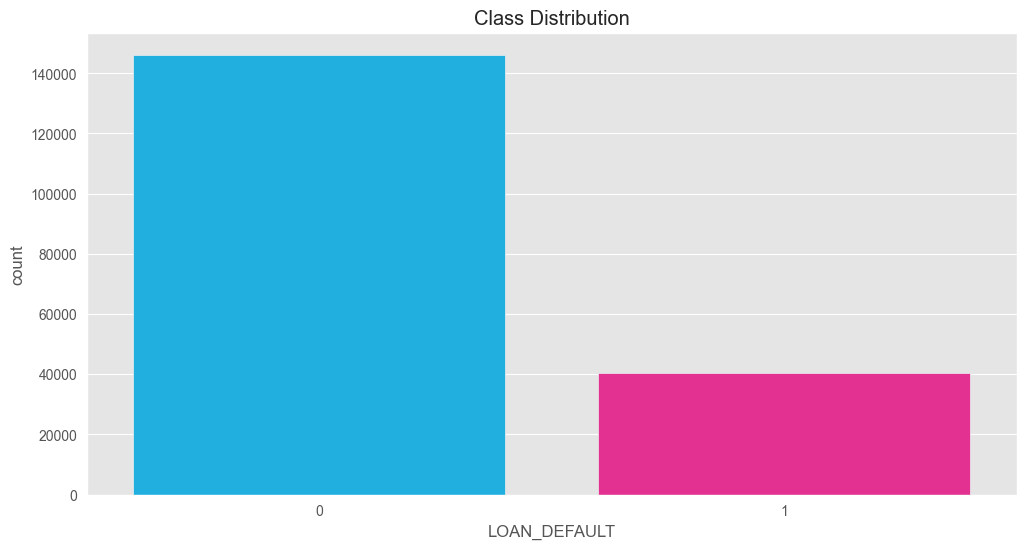

% of no defaults       : 78.39247706717134
Number of no defaults     : 146220
% of defaults         : 21.607522932828658
Number of defaults    : 40303


In [24]:
#Graph

my_pal = {'0': 'deepskyblue', '1': 'deeppink'}

plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'LOAN_DEFAULT', data = train, palette = my_pal)
plt.title('Class Distribution')
plt.show()

# Count and %
Count_Normal_transacation = len(train[train['LOAN_DEFAULT']==0])
Count_Fraud_transacation = len(train[train['LOAN_DEFAULT']==1]) 
Percentage_of_Normal_transacation = Count_Normal_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print('% of no defaults       :', Percentage_of_Normal_transacation*100)
print('Number of no defaults     :', Count_Normal_transacation)
Percentage_of_Fraud_transacation= Count_Fraud_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print('% of defaults         :',Percentage_of_Fraud_transacation*100)
print('Number of defaults    :', Count_Fraud_transacation)

In [25]:
print("Employment type\n")
print(train.groupby(["EMPLOYMENT_TYPE"]).LOAN_DEFAULT.value_counts(normalize=True))
print("##############\n")
print("Mobile Flag\n")
print(train.groupby(["MOBILENO_AVL_FLAG"]).LOAN_DEFAULT.value_counts(normalize=True))
print("##############\n")
print("Aadhar Flag\n")
print(train.groupby(["AADHAR_FLAG"]).LOAN_DEFAULT.value_counts(normalize=True))
print("##############\n")
print("Pan Flag\n")
print(train.groupby(["PAN_FLAG"]).LOAN_DEFAULT.value_counts(normalize=True))
print("##############\n")
print("Voter ID Flag\n")
print(train.groupby(["VOTERID_FLAG"]).LOAN_DEFAULT.value_counts(normalize=True))
print("##############\n")
print("Driving L Flag\n")
print(train.groupby(["DRIVING_FLAG"]).LOAN_DEFAULT.value_counts(normalize=True))
print("##############\n")
print("Passport\n")
print(train.groupby(["PASSPORT_FLAG"]).LOAN_DEFAULT.value_counts(normalize=True))

Employment type

EMPLOYMENT_TYPE  LOAN_DEFAULT
Missing          0               0.783249
                 1               0.216751
Salaried         0               0.796898
                 1               0.203102
Self employed    0               0.774040
                 1               0.225960
Name: proportion, dtype: float64
##############

Mobile Flag

MOBILENO_AVL_FLAG  LOAN_DEFAULT
1                  0               0.783925
                   1               0.216075
Name: proportion, dtype: float64
##############

Aadhar Flag

AADHAR_FLAG  LOAN_DEFAULT
0            0               0.746589
             1               0.253411
1            0               0.791012
             1               0.208988
Name: proportion, dtype: float64
##############

Pan Flag

PAN_FLAG  LOAN_DEFAULT
0         0               0.784099
          1               0.215901
1         0               0.781781
          1               0.218219
Name: proportion, dtype: float64
##############

Voter ID

**Nhóm phát hiện có một dòng trùng dữ liệu.**

In [26]:

print(train.groupby(["LOAN_DEFAULT","EMPLOYMENT_TYPE","AADHAR_FLAG","PAN_FLAG","DRIVING_FLAG","PASSPORT_FLAG"]).VOTERID_FLAG.value_counts(normalize=False))
print("##############\n")


LOAN_DEFAULT  EMPLOYMENT_TYPE  AADHAR_FLAG  PAN_FLAG  DRIVING_FLAG  PASSPORT_FLAG  VOTERID_FLAG
0             Missing          0            0         0             0              1                 342
                                                                    1              0                   9
                                                      1             0              0                  35
                                                                                   1                   3
                                            1         0             0              1                  13
                                                                                   0                   1
                                                      1             0              0                   1
                               1            0         0             0              0                4242
                                                                

In [27]:
train_0 = train[train["LOAN_DEFAULT"]==0]
train_1 = train[train["LOAN_DEFAULT"]==1]

In [28]:
# f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))

# bins = 50

# ax1.hist(train.DISBURSAL_DATE[train.LOAN_DEFAULT == 1], bins = bins, color = 'deeppink')
# ax1.set_title('Default')

# ax2.hist(train.DISBURSAL_DATE[train.LOAN_DEFAULT == 0], bins = bins, color = 'deepskyblue')
# ax2.set_title('No default')

# plt.xlabel('DISBURSAL DATE')
# plt.ylabel('Number of Loans')
# plt.show()

In [29]:
# Plot distribution of one feature
def plot_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()
    
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = train.loc[train['LOAN_DEFAULT'] != 0]
    t0 = train.loc[train['LOAN_DEFAULT'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="LOAN_DEFAULT = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="LOAN_DEFAULT = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

In [30]:
def plot_bar_comp(var,nrow=2):
    
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.countplot(train[feature])
        sns.countplot(train[feature])
        plt.ylabel('Count plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();
    

In [31]:
# Box Plot for one feature
def plot_box(feature, color):
    plt.figure(figsize=(10,6))
    plt.title("Box Plot of %s" % feature)
    sns.boxplot(train[feature].dropna(),color=color)
    plt.show()


In [32]:
# Bar Plot for one feature
def plot_bar(feature):
    plt.figure(figsize=(10,50))
    sns.catplot(y=feature, hue="LOAN_DEFAULT", kind="count",
            palette="pastel", edgecolor=".6",
            data=train);

count    186523.000000
mean      54340.127169
std       13021.133934
min       13320.000000
25%       47145.000000
50%       53803.000000
75%       60347.000000
max      990572.000000
Name: DISBURSED_AMOUNT, dtype: float64


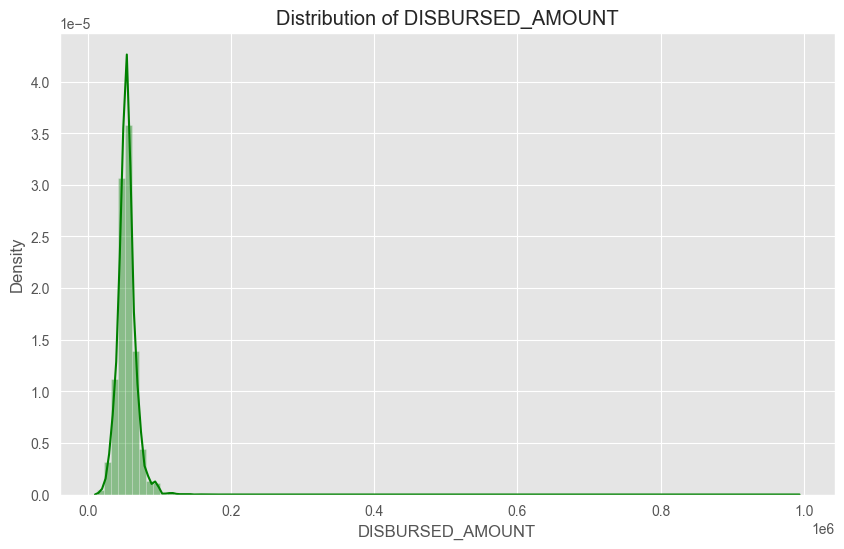

In [33]:
print(train.DISBURSED_AMOUNT.describe())
plot_distribution('DISBURSED_AMOUNT','green')


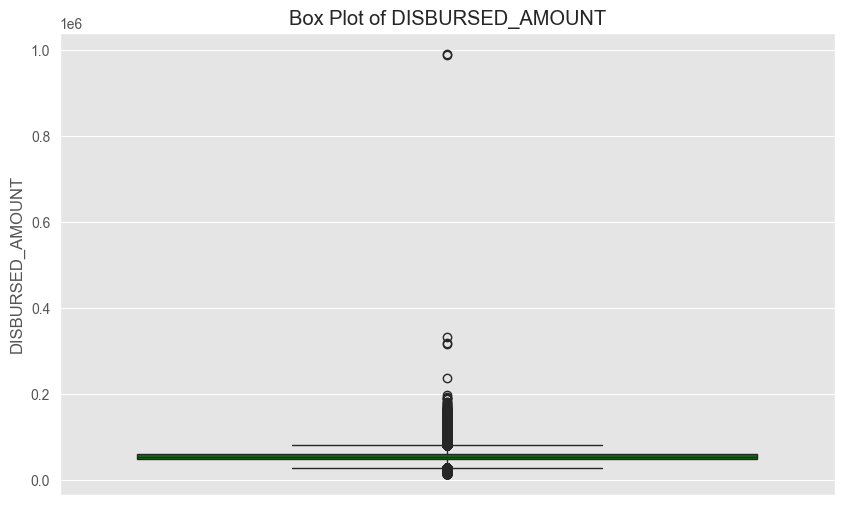

In [34]:
plot_box("DISBURSED_AMOUNT", "green")

In [35]:
#Number of observations in column
obs = len(train.DISBURSED_AMOUNT)
print("No. of observations in column: ",obs)

# calculate summary statistics
data_mean, data_std = mean(train.DISBURSED_AMOUNT), std(train.DISBURSED_AMOUNT)
print('Statistics: Mean=%.3f, Std dev=%.3f' % (data_mean, data_std))
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers
outliers = [x for x in train.DISBURSED_AMOUNT if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

No. of observations in column:  186523
Statistics: Mean=54340.127, Std dev=13021.099
Identified outliers: 2469


In [36]:
def impute_outlier(x):
    if x <= lower:
        return(data_mean)
    elif x>= (upper):
        return(data_mean)
    else:
        return(x)
train["DISBURSED_AMOUNT_new"]= train["DISBURSED_AMOUNT"].apply(impute_outlier)
test["DISBURSED_AMOUNT_new"]= test["DISBURSED_AMOUNT"].apply(impute_outlier)
print("No. of observations in column: ",len(train.DISBURSED_AMOUNT_new))

No. of observations in column:  186523


In [37]:
bin_labels = ['Low', 'Medium', 'High', 'Extreme']
train['DISBURSED_AMOUNT_bins'] = pd.qcut(train['DISBURSED_AMOUNT'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels)
test['DISBURSED_AMOUNT_bins'] = pd.qcut(test['DISBURSED_AMOUNT'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels)
train['DISBURSED_AMOUNT_bins'].value_counts()


DISBURSED_AMOUNT_bins
Medium     46924
Low        46888
Extreme    46588
High       46123
Name: count, dtype: int64

<Figure size 1000x5000 with 0 Axes>

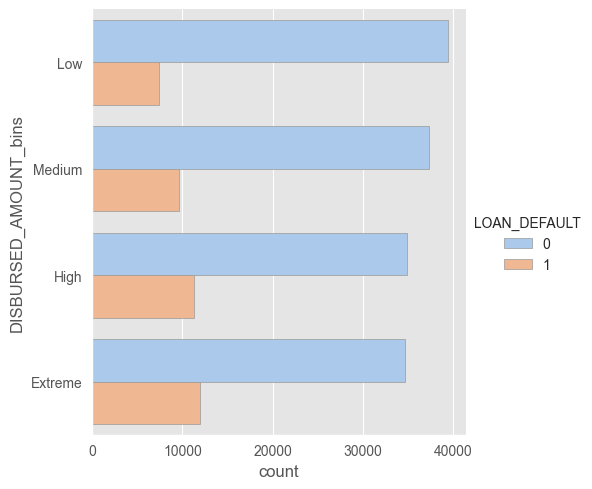

In [38]:
plot_bar("DISBURSED_AMOUNT_bins")

count              186523.0
mean      75835.48979482423
std      18998.526337209107
min                 37000.0
25%                 65728.0
50%                 70929.0
75%                 79147.0
max               1628992.0
Name: ASSET_COST, dtype: object


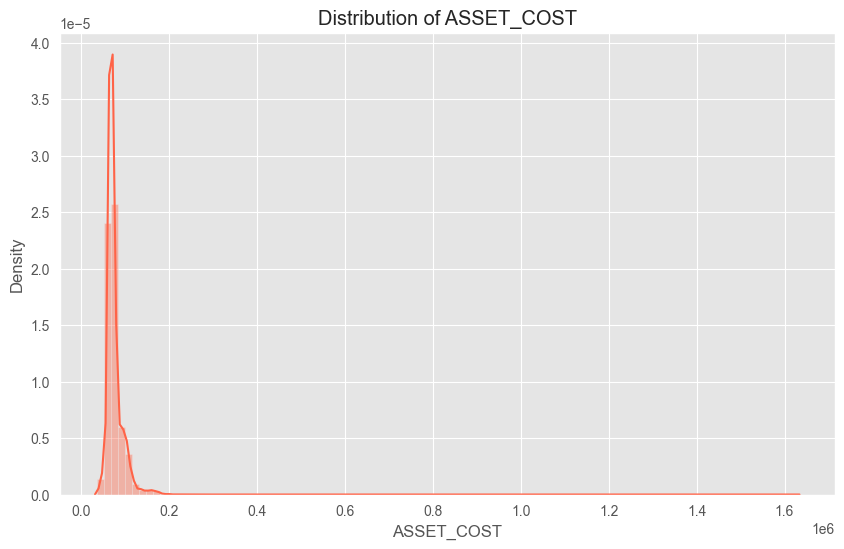

In [39]:
print(train.ASSET_COST.describe().astype(str))
plot_distribution('ASSET_COST','tomato')

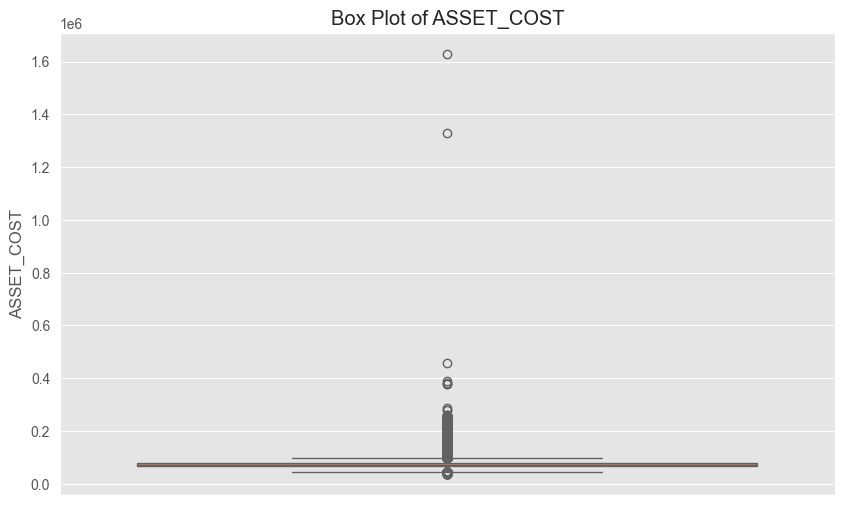

In [40]:
plot_box("ASSET_COST", "tomato")

In [41]:
#Number of observations in column
def outlier_data(df, feature):
    #Number of observations in column
    obs = len(df[feature])
    print("No. of observations in column: ",obs)

    # calculate summary statistics
    data_mean, data_std = mean(df[feature]), std(df[feature])
    print('Statistics: Mean=%.3f, Std dev=%.3f' % (data_mean, data_std))
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # identify outliers
    outliers = [x for x in df[feature] if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))

def impute_outlier(x):
    if x <= lower:
        return(data_mean)
    elif x>= (upper):
        return(data_mean)
    else:
        return(x)

    


In [42]:
outlier_data(train,"ASSET_COST")

No. of observations in column:  186523
Statistics: Mean=75835.490, Std dev=18998.475
Identified outliers: 3531


In [43]:
train["ASSET_COST_new"]= train["ASSET_COST"].apply(impute_outlier)
test["ASSET_COST_new"]= test["ASSET_COST"].apply(impute_outlier)
print("No. of observations in column: ",len(train.DISBURSED_AMOUNT_new))
outlier_data(train,"ASSET_COST_new")

No. of observations in column:  186523
No. of observations in column:  186523
Statistics: Mean=68037.630, Std dev=9609.975
Identified outliers: 44


In [44]:
bin_labels = ['Low', 'Medium', 'High', 'Extreme']
train['ASSET_COST_bins'] = pd.qcut(train['ASSET_COST'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels)
test['ASSET_COST_bins'] = pd.qcut(test['ASSET_COST'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels)
train['ASSET_COST_bins'].value_counts()

ASSET_COST_bins
Medium     46638
Low        46633
Extreme    46630
High       46622
Name: count, dtype: int64

<Figure size 1000x5000 with 0 Axes>

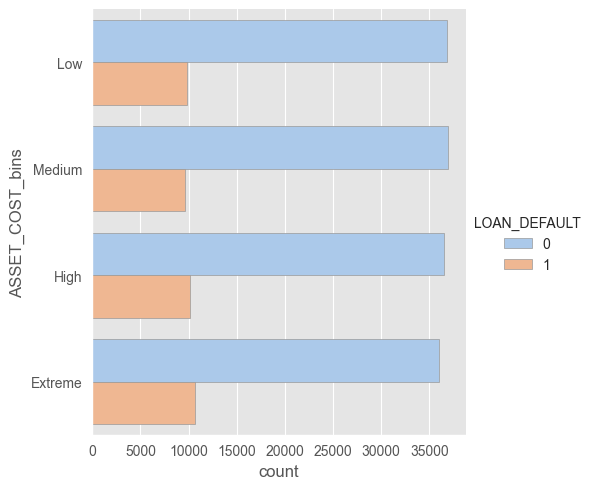

In [45]:
plot_bar("ASSET_COST_bins")

count              186523.0
mean      74.74546093511256
std      11.446309990132475
min                    13.5
25%                   68.88
50%                   76.79
75%                   83.67
max                    95.0
Name: LTV, dtype: object


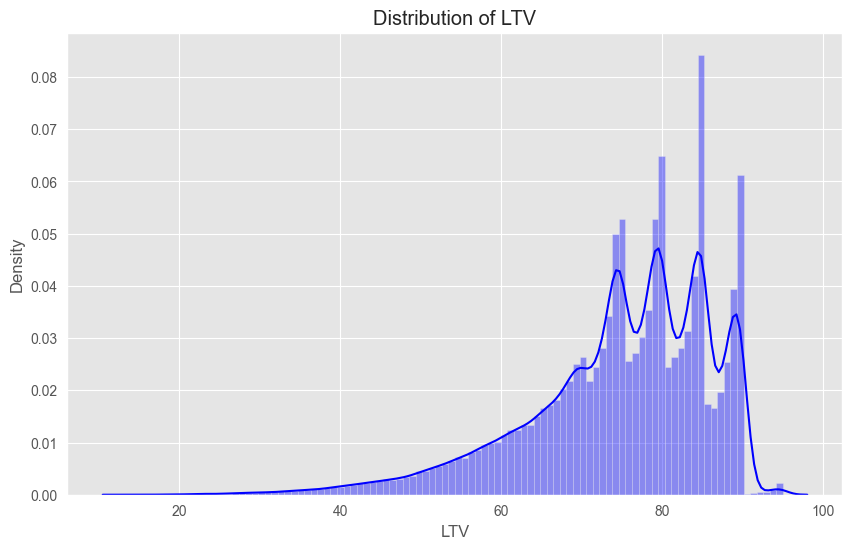

In [46]:
print(train.LTV.describe().astype(str))
plot_distribution('LTV','blue')


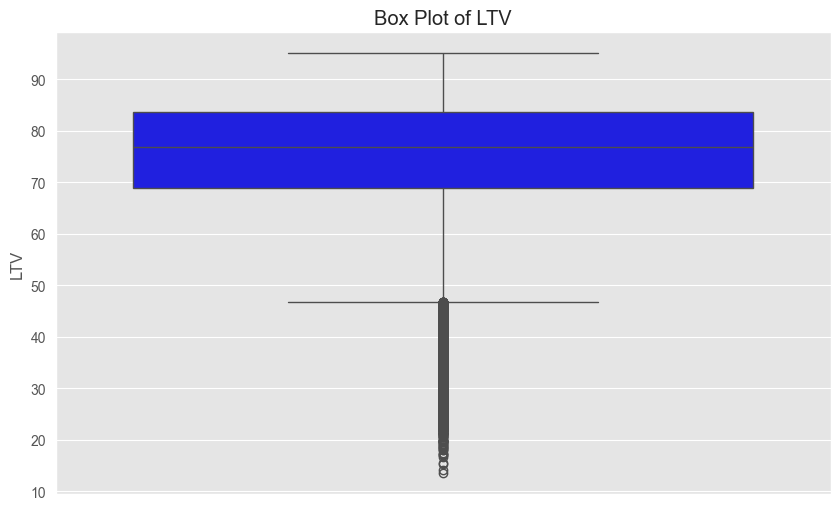

In [47]:
plot_box("LTV", "blue")


In [48]:
outlier_data(train,"LTV")

No. of observations in column:  186523
Statistics: Mean=74.745, Std dev=11.446
Identified outliers: 2181


In [49]:
train["LTV_new"]= train["LTV"].apply(impute_outlier)
print("No. of observations in column: ",len(train.LTV_new))
outlier_data(train,"LTV_new")

No. of observations in column:  186523
No. of observations in column:  186523
Statistics: Mean=54340.127, Std dev=0.000
Identified outliers: 0


In [50]:
bin_labels = ['Low', 'Medium', 'High', 'Extreme']
train['LTV_bins'] = pd.qcut(train['LTV'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels)
train['LTV_bins'].value_counts()


LTV_bins
High       46657
Low        46632
Medium     46630
Extreme    46604
Name: count, dtype: int64

In [51]:
def check_outliers(name,outliers_list):
    we=data[name].values
    Q1=np.quantile(we,0.25)
    Q3=np.quantile(we,0.75)
    IQR=Q3-Q1
    print("Q1: ",Q1,"Q3: ",Q3,"IQR:",IQR)
    outliers=np.unique(we[[(n<Q1-1.5*IQR)|(n>Q3+1.5*IQR) for n in we]])
    indexes=[we.tolist().index(i) for i in outliers]
    if len(indexes)>0:
        outliers_list.append(name)
    print("Indexes of outliers: ", indexes)
    print("Number of outliers: ", len(indexes))
    print("Outlier values", we[indexes])
    print("-----")

KẾT LUẬN
- Dựa vào ma trận tương quan trên, ta nhận thấy những biến có tương quan mạnh : Income_converted & Home_val_converted (0.578943),Income_converted & car_age (0.417301), Home_val_converted & car_age (0.223198).
- Hầu như các biến không tương quan với nhau.

<Figure size 1000x5000 with 0 Axes>

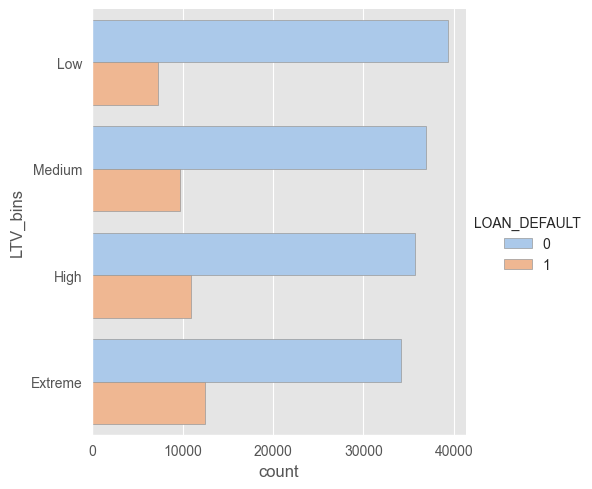

In [52]:
plot_bar("LTV_bins")


count     186523
unique       572
top            0
freq       93648
Name: PERFORM_CNS_SCORE, dtype: object


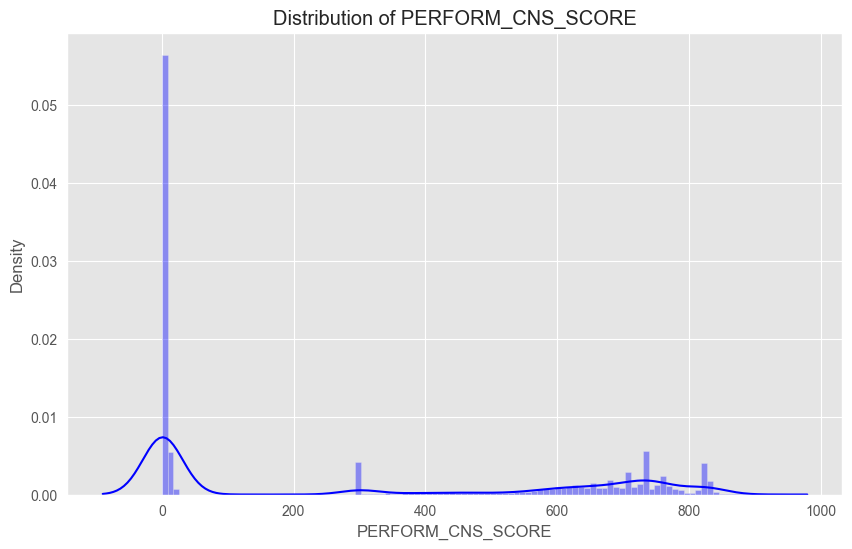

In [53]:
print(train.PERFORM_CNS_SCORE.describe().astype(str))
plot_distribution('PERFORM_CNS_SCORE','blue')


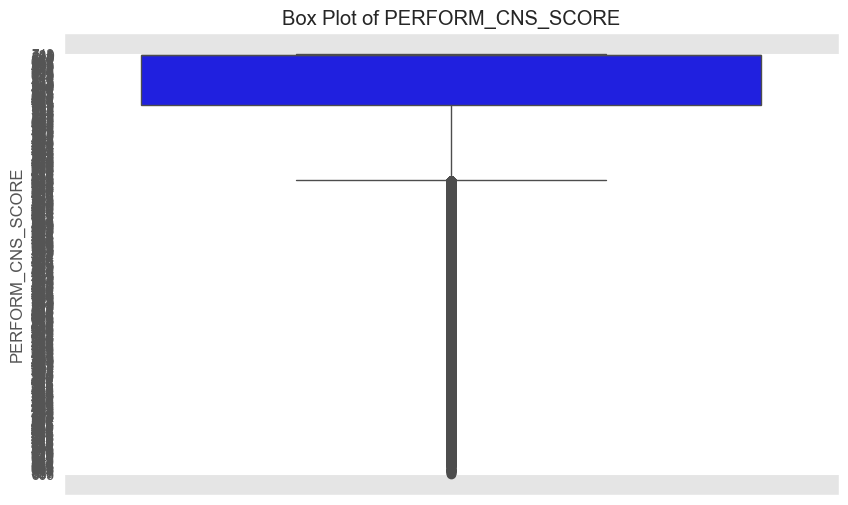

In [54]:
plot_box("PERFORM_CNS_SCORE", "blue")

In [57]:
outlier_data(train,"PERFORM_CNS_SCORE")

No. of observations in column:  186523
Statistics: Mean=289.388, Std dev=338.442
Identified outliers: 0


In [58]:

bin_labels = ["No History",'Very Low', "Low" ,'Medium', 'High']
cut_bins = [-1,10,150, 350, 650, 1000]

train['PERFORM_CNS_SCORE_bins'] = pd.cut(train['PERFORM_CNS_SCORE'],
                              bins=cut_bins,
                              labels=bin_labels)
test['PERFORM_CNS_SCORE_bins'] = pd.cut(test['PERFORM_CNS_SCORE'],
                              bins=cut_bins,
                              labels=bin_labels)
train['PERFORM_CNS_SCORE_bins'].value_counts()


TypeError: '<' not supported between instances of 'int' and 'str'

<Figure size 1000x5000 with 0 Axes>

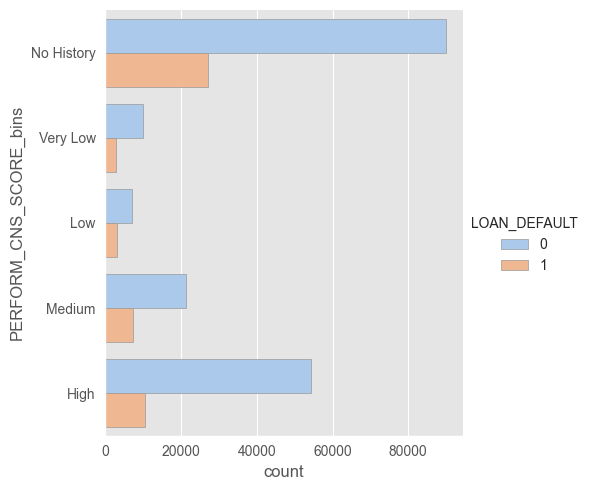

In [ ]:
plot_bar("PERFORM_CNS_SCORE_bins")

In [ ]:
train.groupby(["PERFORM_CNS_SCORE_DESCRIPTION"]).PERFORM_CNS_SCORE_bins.value_counts()

PERFORM_CNS_SCORE_DESCRIPTION                            PERFORM_CNS_SCORE_bins
A-Very Low Risk                                          High                       14124
                                                         No History                     0
                                                         Medium                         0
                                                         Low                            0
                                                         Very Low                       0
B-Very Low Risk                                          High                        9201
                                                         Medium                         0
                                                         Low                            0
                                                         Very Low                       0
                                                         No History                     0
C-Very Low Risk     

In [ ]:
train.PERFORM_CNS_SCORE_DESCRIPTION.value_counts()

PERFORM_CNS_SCORE_DESCRIPTION
No Bureau History Available                                116950
C-Very Low Risk                                             16045
A-Very Low Risk                                             14124
D-Very Low Risk                                             11358
B-Very Low Risk                                              9201
M-Very High Risk                                             8776
F-Low Risk                                                   8485
K-High Risk                                                  8277
H-Medium Risk                                                6855
E-Low Risk                                                   5821
I-Medium Risk                                                5557
G-Low Risk                                                   3988
Not Scored: Sufficient History Not Available                 3765
J-High Risk                                                  3748
Not Scored: Not Enough Info available on the c

In [ ]:
g = train.groupby("PERFORM_CNS_SCORE_DESCRIPTION")['LOAN_DEFAULT']
gg = pd.concat([g.value_counts(), 
                g.value_counts(normalize=True).mul(100)],axis=1, keys=('counts','percentage'))
print (gg)

#train.groupby("PERFORM_CNS_SCORE_DESCRIPTION").LOAN_DEFAULT.value_counts(normalize=False)

                                                                 counts  percentage
PERFORM_CNS_SCORE_DESCRIPTION                      LOAN_DEFAULT                    
A-Very Low Risk                                    0              11783   83.425375
                                                   1               2341   16.574625
B-Very Low Risk                                    0               7993   86.870992
                                                   1               1208   13.129008
C-Very Low Risk                                    0              13275   82.736055
                                                   1               2770   17.263945
D-Very Low Risk                                    0               9659   85.041381
                                                   1               1699   14.958619
E-Low Risk                                         0               4821   82.820821
                                                   1               1000   17

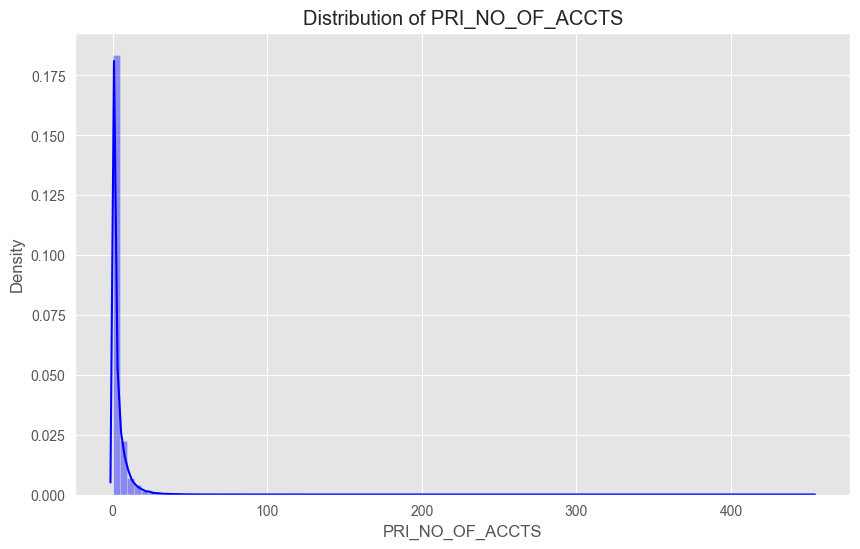

In [ ]:

plot_distribution('PRI_NO_OF_ACCTS','blue')


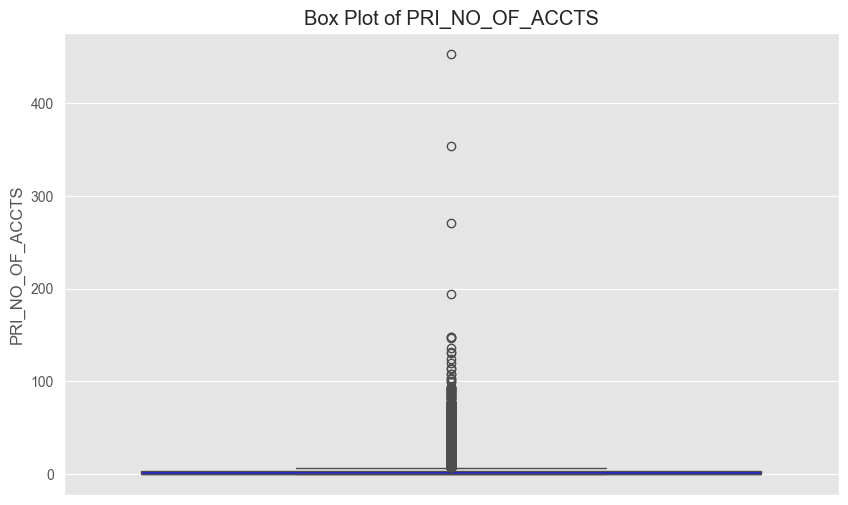

In [ ]:
plot_box("PRI_NO_OF_ACCTS", "blue")

In [ ]:
outlier_data(train,"PRI_NO_OF_ACCTS")

No. of observations in column:  233154
Statistics: Mean=2.441, Std dev=5.217
Identified outliers: 4119


In [ ]:
train["PRI_NO_OF_ACCTS_new"]= train["PRI_NO_OF_ACCTS"].apply(impute_outlier)
test["PRI_NO_OF_ACCTS_new"]= test["PRI_NO_OF_ACCTS"].apply(impute_outlier)
outlier_data(train,"PRI_NO_OF_ACCTS_new")

No. of observations in column:  233154
Statistics: Mean=54356.994, Std dev=0.000
Identified outliers: 0


## KẾT LUẬN
-Tỉ lệ hồ sơ yêu cầu bồi thường bảo hiểm có sự chênh lệch quá lớn. Số hồ sơ không yêu cầu bổi thường gấp 3 lần số hồ sơ yêu cầu bồi thường. => (Imbalanced variable)

In [ ]:
bin_labels = ["One",'More than One']
cut_bins = [-1,1, 1000]

train['PRI_NO_OF_ACCTS_bins'] = pd.cut(train['PRI_NO_OF_ACCTS'],
                              bins=cut_bins,
                              labels=bin_labels)
test['PRI_NO_OF_ACCTS_bins'] = pd.cut(test['PRI_NO_OF_ACCTS'],
                              bins=cut_bins,
                              labels=bin_labels)
train['PRI_NO_OF_ACCTS_bins'].value_counts()

PRI_NO_OF_ACCTS_bins
One              151928
More than One     81226
Name: count, dtype: int64

<Figure size 1000x5000 with 0 Axes>

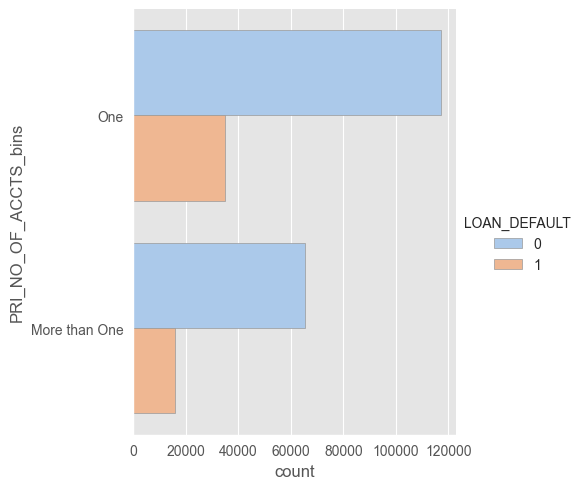

In [ ]:
plot_bar("PRI_NO_OF_ACCTS_bins")

count               233154.0
mean     0.15654889043293274
std       0.5487867498775106
min                      0.0
25%                      0.0
50%                      0.0
75%                      0.0
max                     25.0
Name: PRI_OVERDUE_ACCTS, dtype: object


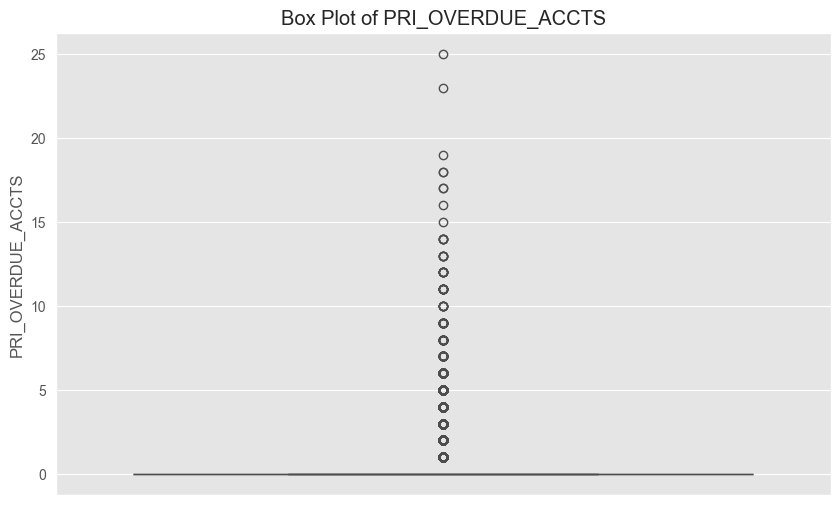

In [ ]:
print(train.PRI_OVERDUE_ACCTS.describe().astype(str))
plot_box("PRI_OVERDUE_ACCTS", "blue")

In [ ]:
outlier_data(train,"PRI_OVERDUE_ACCTS")


No. of observations in column:  233154
Statistics: Mean=0.157, Std dev=0.549
Identified outliers: 6305


In [ ]:
train["PRI_OVERDUE_ACCTS_new"]= train["PRI_OVERDUE_ACCTS"].apply(impute_outlier)
test["PRI_OVERDUE_ACCTS_new"]= test["PRI_OVERDUE_ACCTS"].apply(impute_outlier)
outlier_data(train,"PRI_OVERDUE_ACCTS_new")


No. of observations in column:  233154
Statistics: Mean=54356.994, Std dev=0.000
Identified outliers: 0


<Figure size 1000x5000 with 0 Axes>

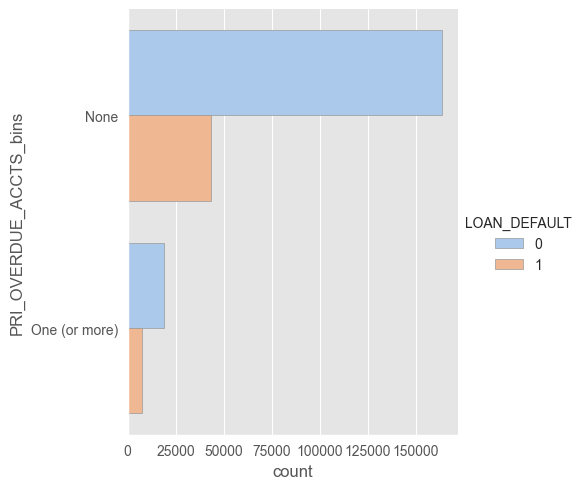

In [ ]:
bin_labels = ["None",'One (or more)']
cut_bins = [-1,0, 1000]

train['PRI_OVERDUE_ACCTS_bins'] = pd.cut(train['PRI_OVERDUE_ACCTS'],
                              bins=cut_bins,
                              labels=bin_labels)
train['PRI_OVERDUE_ACCTS_bins'].value_counts()
plot_bar("PRI_OVERDUE_ACCTS_bins")

<Figure size 1000x5000 with 0 Axes>

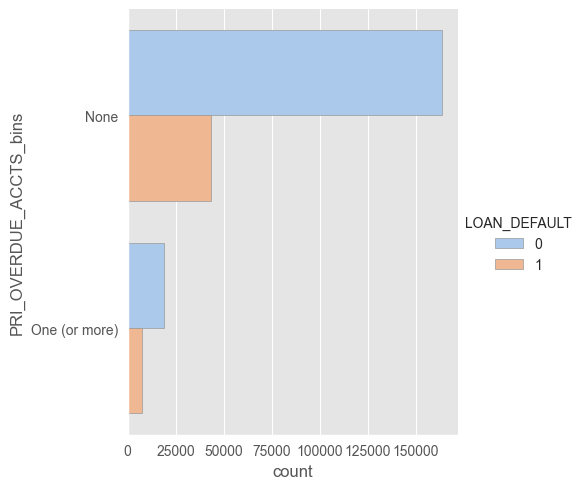

In [ ]:
bin_labels = ["None",'One (or more)']
cut_bins = [-1,0, 1000]

test['PRI_OVERDUE_ACCTS_bins'] = pd.cut(test['PRI_OVERDUE_ACCTS'],
                              bins=cut_bins,
                              labels=bin_labels)
test['PRI_OVERDUE_ACCTS_bins'].value_counts()
plot_bar("PRI_OVERDUE_ACCTS_bins")

In [ ]:
# var = ['MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG', 'PASSPORT_FLAG', 'DRIVING_FLAG']
# plot_bar_comp(var,nrow=3)

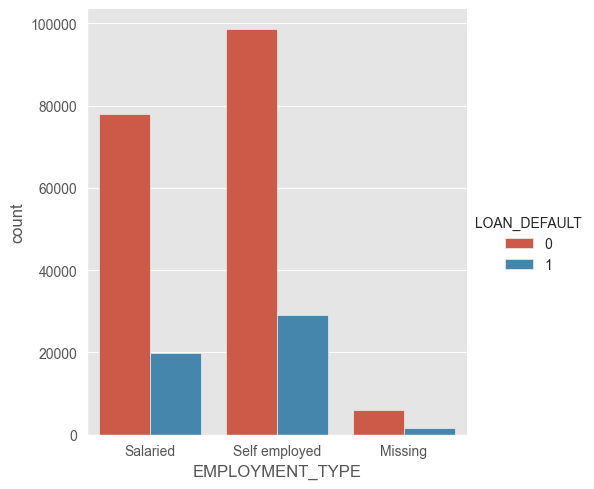

In [ ]:
sns.catplot(data=train,kind='count',x='EMPLOYMENT_TYPE',hue='LOAN_DEFAULT')


In [ ]:
now = pd.Timestamp('now')
#train['DATE_OF_BIRTH'] = train['DATE_OF_BIRTH'].where(train['DATE_OF_BIRTH'] < now, train['DATE_OF_BIRTH'] -  np.timedelta64(100, 'Y'))   
train['age'] = (now - train['DATE_OF_BIRTH'])  

train['age']= train['age'].astype(str)
train[['age','age_waste']] = train['age'].str.split("days",expand=True)
train['age']= train['age'].astype(str).astype(int)
train= train.drop(columns= ['age_waste'])

print(train['age'].head())

0    15033
1    14456
2    14432
3    11382
4    17247
Name: age, dtype: int32


In [ ]:
# now = pd.Timestamp('now')
#train['DATE_OF_BIRTH'] = train['DATE_OF_BIRTH'].where(train['DATE_OF_BIRTH'] < now, train['DATE_OF_BIRTH'] -  np.timedelta64(100, 'Y'))   
test['age'] = (now - test['DATE_OF_BIRTH'])  

test['age']= test['age'].astype(str)
test[['age','age_waste']] = test['age'].str.split("days",expand=True)
test['age']= test['age'].astype(str).astype(int)
test= test.drop(columns= ['age_waste'])

print(test['age'].head())

0    18685
1    14528
2    10729
3    18899
4    19264
Name: age, dtype: int32


In [ ]:
train['disbursal_time'] = (now - train['DISBURSAL_DATE'])  

train['disbursal_time']= train['disbursal_time'].astype(str)
train[['disbursal_time','disbursal_time_waste']] = train['disbursal_time'].str.split("days",expand=True)
train['disbursal_time']= train['disbursal_time'].astype(str).astype(int)
train= train.drop(columns= ['disbursal_time_waste'])

print(train['disbursal_time'].head())

0    2400
1    2346
2    2402
3    2316
4    2346
Name: disbursal_time, dtype: int32


In [ ]:
test['disbursal_time'] = (now - test['DISBURSAL_DATE'])  

test['disbursal_time']= test['disbursal_time'].astype(str)
test[['disbursal_time','disbursal_time_waste']] = test['disbursal_time'].str.split("days",expand=True)
test['disbursal_time']= test['disbursal_time'].astype(str).astype(int)
test= test.drop(columns= ['disbursal_time_waste'])

print(test['disbursal_time'].head())


0    2308
1    2291
2    2282
3    2282
4    2294
Name: disbursal_time, dtype: int32


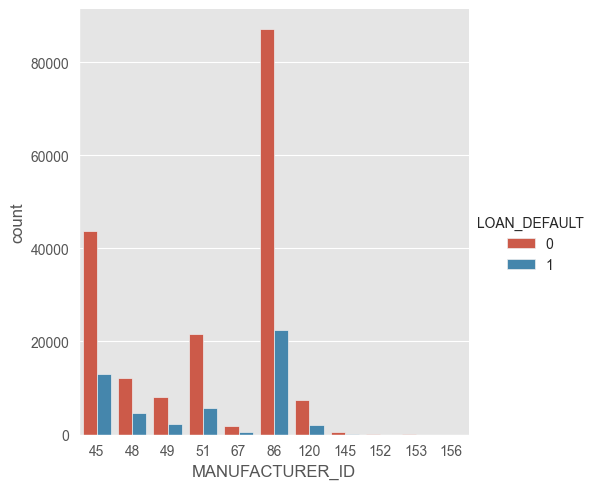

In [ ]:
sns.catplot(data=train,kind='count',x='MANUFACTURER_ID',hue='LOAN_DEFAULT')


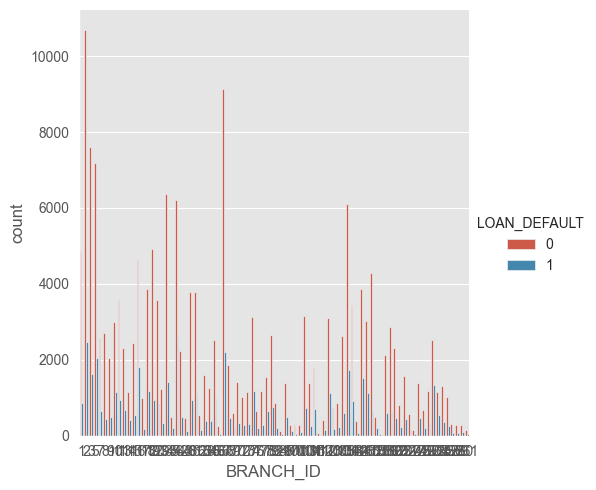

In [ ]:
sns.catplot(data=train,kind='count',x='BRANCH_ID',hue='LOAN_DEFAULT')

In [ ]:
#Useless features
#train = train.drop(['DISBURSED_AMOUNT','ASSET_COST', 'LTV', 'PRI_NO_OF_ACCTS','PRI_OVERDUE_ACCTS', 'DATE_OF_BIRTH', 'DISBURSAL_DATE', 'STATE_ID', 'EMPLOYEE_CODE_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID','BRANCH_ID'],axis=1)
train = train.drop([ 'DATE_OF_BIRTH' , 'STATE_ID', 'EMPLOYEE_CODE_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID','BRANCH_ID'],axis=1)
test = test.drop([ 'DATE_OF_BIRTH' , 'STATE_ID', 'EMPLOYEE_CODE_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID','BRANCH_ID'],axis=1)

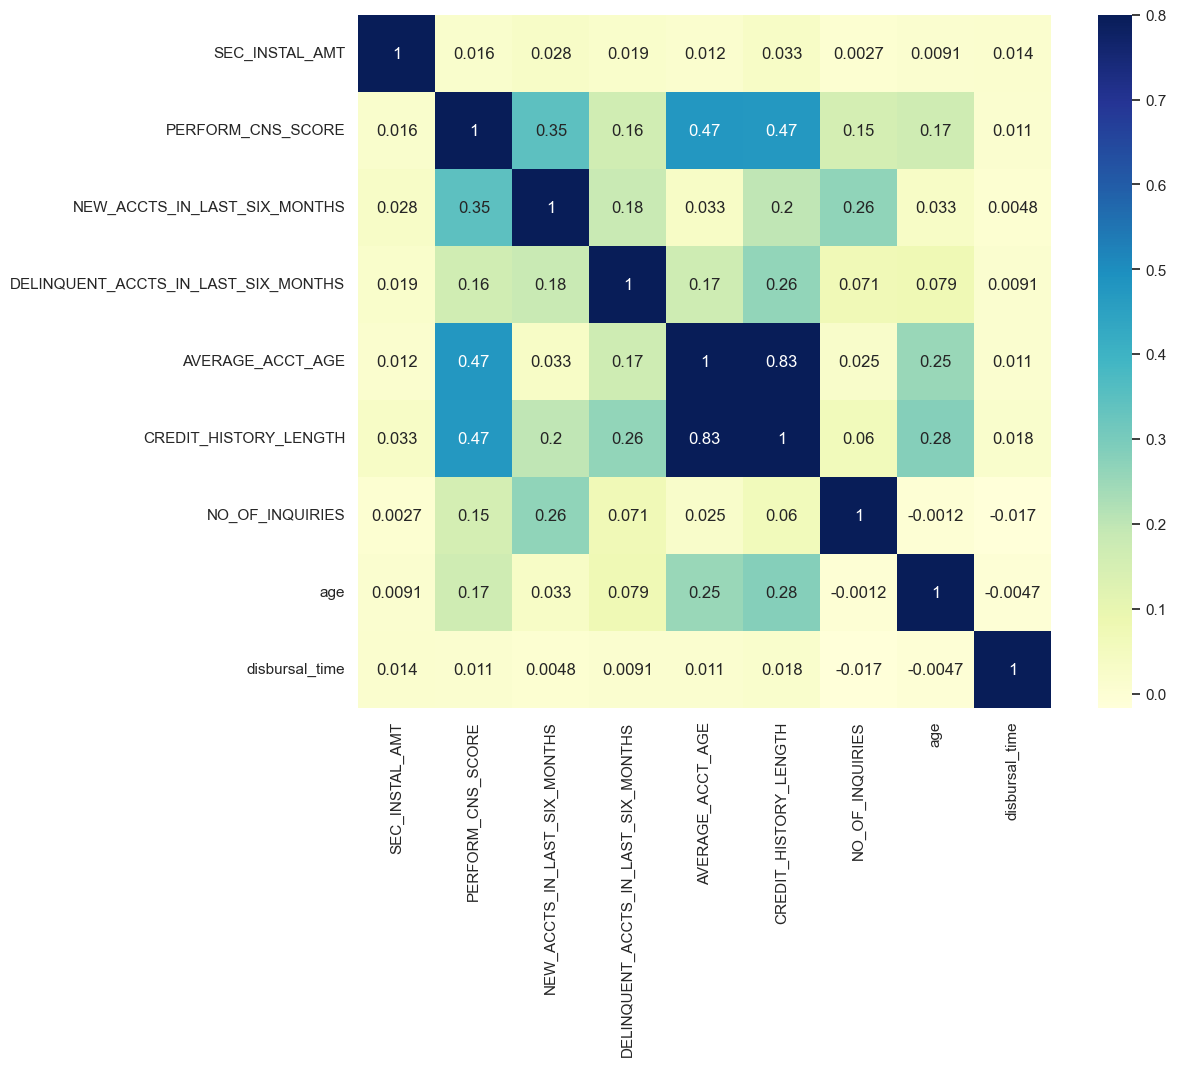

In [ ]:
#Highly Correlated
sns.set()

cols = train[['SEC_INSTAL_AMT', 'PERFORM_CNS_SCORE','NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 
              'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES','age', 'disbursal_time']]
corr = cols.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, annot=True, vmax=.8, square=True,cmap = 'YlGnBu');

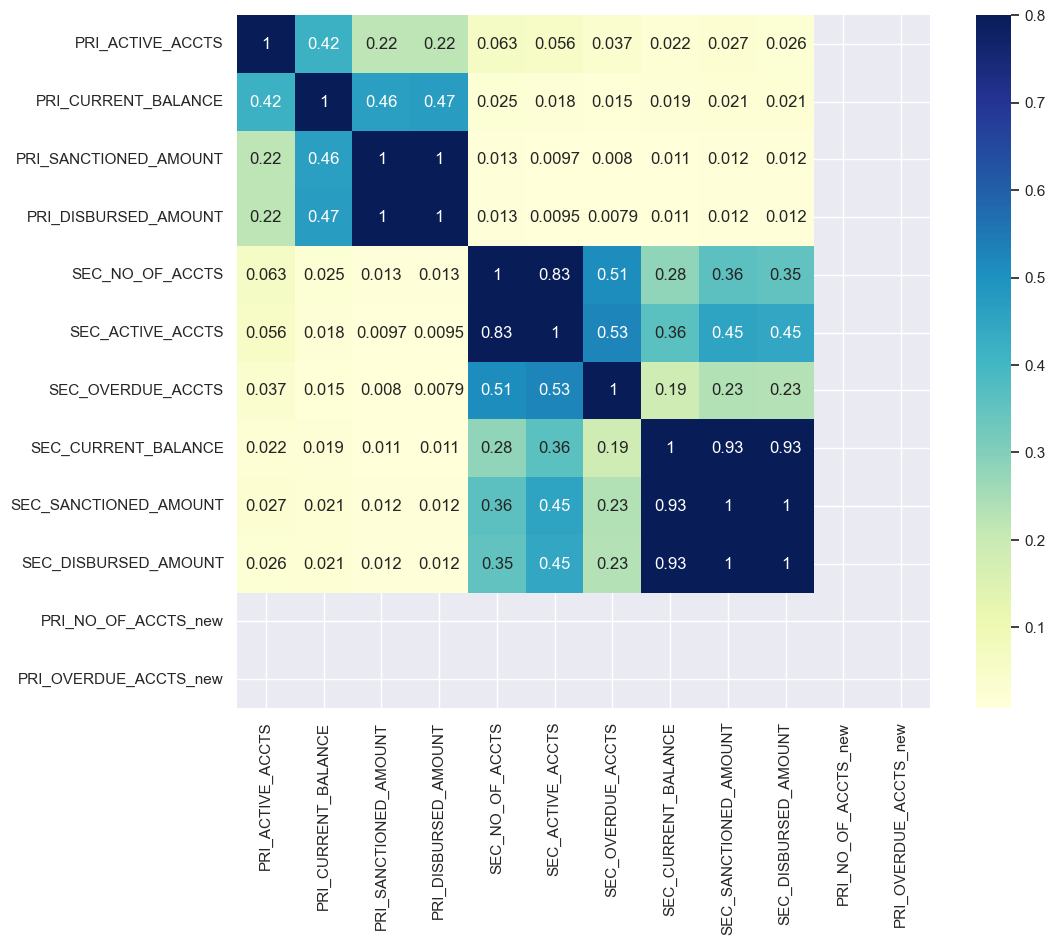

In [ ]:
#Highly Correlated
sns.set()

cols = train[['PRI_ACTIVE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 
              'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT',
              'SEC_DISBURSED_AMOUNT',  'PRI_NO_OF_ACCTS_new', 'PRI_OVERDUE_ACCTS_new']]
corr = cols.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, annot=True, vmax=.8, square=True,cmap = 'YlGnBu');


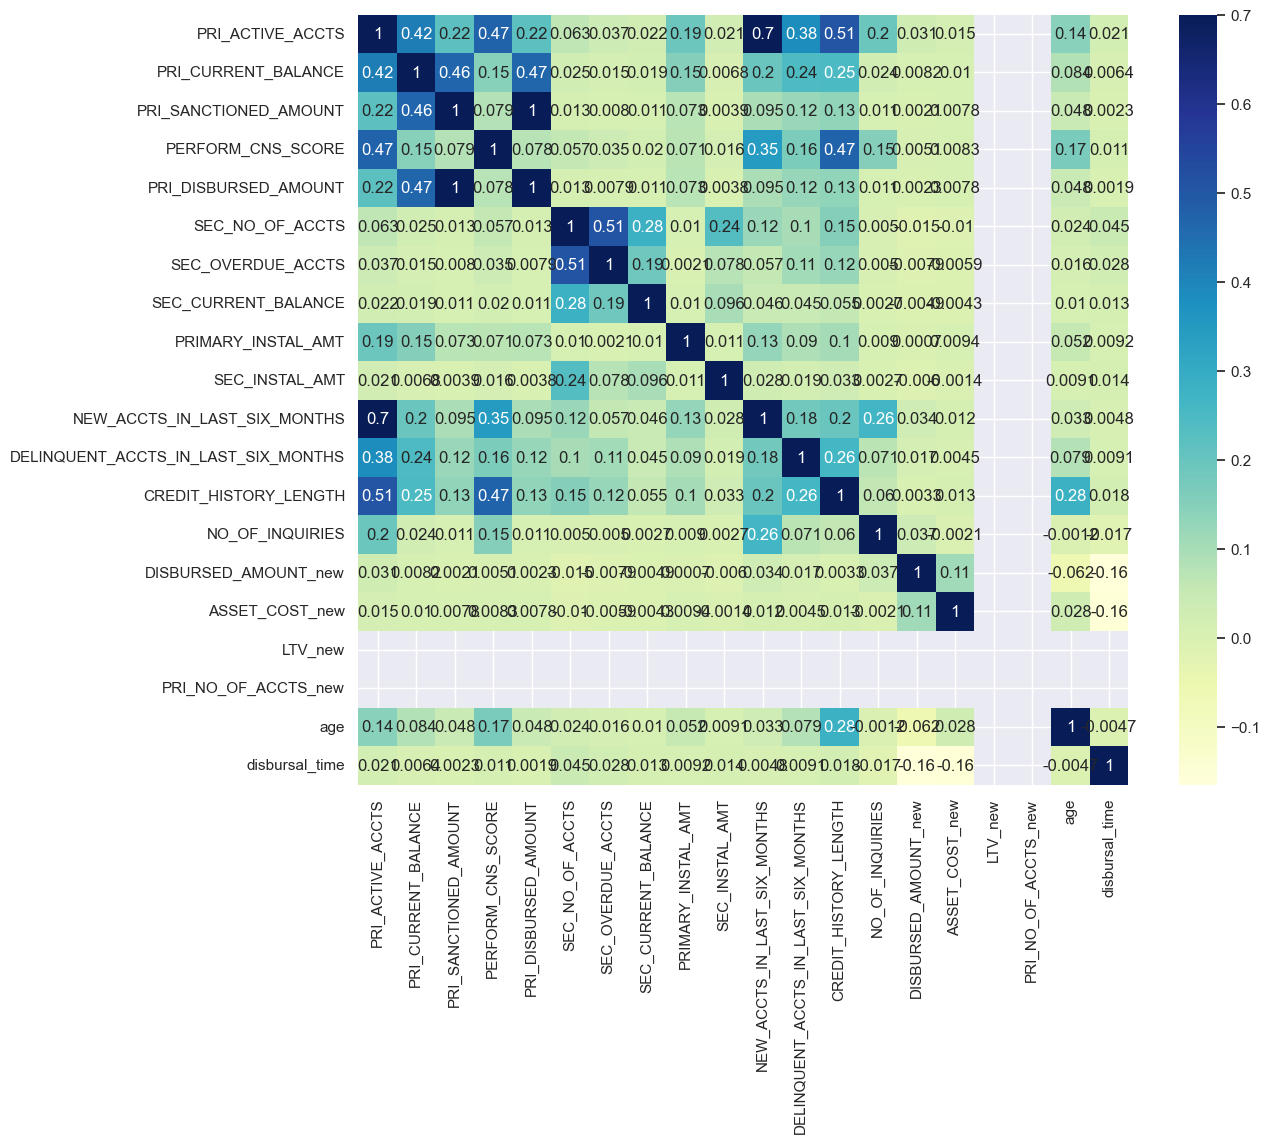

In [ ]:
#Highly Correlated
sns.set()

cols = train[['PRI_ACTIVE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PERFORM_CNS_SCORE',
              'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE',
              'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS', 
              'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES',
              'DISBURSED_AMOUNT_new','ASSET_COST_new','LTV_new','PRI_NO_OF_ACCTS_new','age', 'disbursal_time']]
corr = cols.corr()
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(corr, annot=True, vmax=.7, square=True,cmap = 'YlGnBu');

In [ ]:
train.to_csv(f'{save_dir}/train_EDA.csv',index=None)
test.to_csv(f'{save_dir}/test_EDA.csv',index=None)